In [1]:
import sys

sys.path.append('../kaggle')

In [151]:
from typing import Dict, List, Set, Optional, Tuple

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances

In [3]:
np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(precision=6, suppress=True)

## Load Dataset

In [4]:
df = pd.read_csv('../kaggle/train.csv')
print(df.shape)

(5237980, 17)


## Analyze the Missing Pattern of Dates for Each Stock

In [51]:
def PrintStockMissingDate(df: pd.DataFrame) -> None:
    def ranges(nums):
        nums = sorted(set(nums))
        gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
        edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
        return list(zip(edges, edges))

    stock_list: List[int] = df['stock_id'].unique().tolist()
    date_list: List[int] = df['date_id'].unique().tolist()
    stock_list.sort(reverse=False)
    date_list.sort(reverse=False)

    for stock_id in stock_list:
        stock_df: pd.DataFrame = df.loc[df['stock_id'] == stock_id]
        missing_dates: List[int] = []

        for date in date_list:
            if date not in stock_df['date_id'].to_list():
                missing_dates.append(date)
        
        if len(missing_dates) > 0:
            print(f'Stock {stock_id}: {ranges(missing_dates)}')

PrintStockMissingDate(df=df)

Stock 69: [(0, 36)]
Stock 73: [(320, 320)]
Stock 78: [(0, 3)]
Stock 79: [(0, 180)]
Stock 99: [(138, 138)]
Stock 102: [(0, 294)]
Stock 135: [(0, 190)]
Stock 150: [(0, 58)]
Stock 153: [(0, 69)]
Stock 156: [(0, 36)]
Stock 199: [(0, 87)]


## Missing Column Statistics

According to the information from Kaggle, exactly 220 days of data are missing in these fields:

- `imbalance_size`
- `reference_price`
- `matched_size`
- `bid_price`
- `ask_price`
- `wap`

This analysis aims to check if these fields were missing in the same days and stocks or not.

In [49]:
def CheckMissingDateOfFields(df: pd.DataFrame) -> None:
    date_list: List[int] = df['date_id'].unique().tolist()
    date_list.sort(reverse=False)
    msg_list: List[str] = []

    with tqdm(total=len(date_list), desc='Search for missing fields by dates and stocks') as pbar:
        for date in date_list:
            date_df: pd.DataFrame = df.loc[df['date_id'] == date]

            stock_list: List[int] = date_df['stock_id'].unique().tolist()
            stock_list.sort(reverse=False)

            for stock in stock_list:
                stock_df: pd.DataFrame = date_df.loc[df['stock_id'] == stock]
                row_cnt: int = stock_df.shape[0]

                for field_name in df.columns:
                    if field_name == 'far_price' or field_name == 'near_price':
                        continue
                    field: pd.Series = stock_df[field_name]
                    missing_cnt: int = field.isnull().sum()
                    if missing_cnt == row_cnt:
                        msg_list.append(
                            f'Date {date:3} - Stock {stock:3}: The `{field_name}` of all rows were missed.'
                        )
                    elif missing_cnt > 0:
                        msg_list.append(
                            f'Date {date:3} - Stock {stock:3}: The `{field_name}` of {missing_cnt} row(s) were missed.'
                        )

            pbar.update(1)

    for msg in msg_list:
        print(msg)

CheckMissingDateOfFields(df=df)

Search for missing fields by dates and stocks: 100%|██████████| 481/481 [03:13<00:00,  2.48it/s]

Date  35 - Stock 131: The `imbalance_size` of all rows were missed.
Date  35 - Stock 131: The `reference_price` of all rows were missed.
Date  35 - Stock 131: The `matched_size` of all rows were missed.
Date  35 - Stock 131: The `bid_price` of all rows were missed.
Date  35 - Stock 131: The `ask_price` of all rows were missed.
Date  35 - Stock 131: The `wap` of all rows were missed.
Date  35 - Stock 131: The `target` of 31 row(s) were missed.
Date 328 - Stock 101: The `imbalance_size` of all rows were missed.
Date 328 - Stock 101: The `reference_price` of all rows were missed.
Date 328 - Stock 101: The `matched_size` of all rows were missed.
Date 328 - Stock 101: The `bid_price` of all rows were missed.
Date 328 - Stock 101: The `ask_price` of all rows were missed.
Date 328 - Stock 101: The `wap` of all rows were missed.
Date 328 - Stock 101: The `target` of 1 row(s) were missed.
Date 388 - Stock 158: The `imbalance_size` of all rows were missed.
Date 388 - Stock 158: The `reference_pr

In [25]:
df.loc[df['date_id'] == 35][df['stock_id'] == 131]

/var/folders/nj/r29m7nhj6cx5cccn34l5xpf00000gn/T/ipykernel_85195/2101906282.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.loc[df['date_id'] == 35][df['stock_id'] == 131]


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
369508,131,35,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1925,35_0_131
369700,131,35,10,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1926,35_10_131
369892,131,35,20,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1927,35_20_131
370084,131,35,30,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1928,35_30_131
370276,131,35,40,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1929,35_40_131
370468,131,35,50,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1930,35_50_131
370660,131,35,60,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1931,35_60_131
370852,131,35,70,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1932,35_70_131
371044,131,35,80,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1933,35_80_131
371236,131,35,90,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1934,35_90_131


## How Many Dates Do Not Have All Stocks

In [40]:
def PrintDateNoAllStocks(df: pd.DataFrame)-> None:
    date_list: List[int] = df['date_id'].unique().tolist()
    date_list.sort(reverse=False)
    total_stock_cnt: int = len(df['stock_id'].unique().tolist())
    stock_cnt_dates: Dict[int, int] = {}
    incompleted_date_cnt: int = 0

    for date in date_list:
        date_df: pd.DataFrame = df.loc[df['date_id'] == date]
        stock_list: List[int] = date_df['stock_id'].unique().tolist()
        if len(stock_list) not in stock_cnt_dates:
            stock_cnt_dates[len(stock_list)] = 1
        else:
            stock_cnt_dates[len(stock_list)] += 1

    for key, value in stock_cnt_dates.items():
        incompleted_date_cnt += value if key != total_stock_cnt else 0
        print(f'There are {value:3} days that have {key:3} stocks.')

    print(f'Imcompleted date ratio = {incompleted_date_cnt / len(date_list) * 100}%')

PrintDateNoAllStocks(df=df)

There are   4 days that have 191 stocks.
There are  33 days that have 192 stocks.
There are  22 days that have 194 stocks.
There are  11 days that have 195 stocks.
There are  19 days that have 196 stocks.
There are  92 days that have 197 stocks.
There are  10 days that have 198 stocks.
There are 105 days that have 199 stocks.
There are 185 days that have 200 stocks.
Imcompleted date ratio = 61.53846153846154%


## The Pattern of Missed `Far Price` and `Near Price`

In [48]:
def PrintMissedPricePattern(df: pd.DataFrame) -> None:
    date_list: List[int] = df['date_id'].unique().tolist()
    date_list.sort(reverse=False)
    first_exist_sec: Dict[int, int] = {}

    with tqdm(total=len(date_list), desc='Iterate over each second of all dates') as pbar:
        for date in date_list:
            date_df: pd.DataFrame = df.loc[df['date_id'] == date]
            stock_list: List[int] = date_df['stock_id'].unique().tolist()

            for stock in stock_list:
                stock_df: pd.DataFrame = date_df.loc[date_df['stock_id'] == stock]
                for field_name in date_df.columns:
                    if field_name == 'far_price' or field_name == 'near_price':
                        continue
                    if stock_df[field_name].isnull().values.any():
                        indices = date_df[date_df['stock_id'] == stock].index
                        date_df = date_df.drop(indices, inplace=False)
                        continue

            sec_list: List[int] = date_df['seconds_in_bucket'].unique().tolist()
            sec_list.sort(reverse=False)
            for sec in sec_list:
                sec_df: pd.DataFrame = date_df.loc[date_df['seconds_in_bucket'] == sec]
                if (
                    not sec_df['far_price'].isnull().values.any()
                    and not sec_df['near_price'].isnull().values.any()
                ):
                    if sec not in first_exist_sec:
                        first_exist_sec[sec] = 1
                    else:
                        first_exist_sec[sec] += 1
                    continue
            pbar.update(1)

    for key, value in first_exist_sec.items():
        print(
            f'Both `near_price` and `far_price` of {value:3} days are not NaN from the second {key:3}.'
        )


PrintMissedPricePattern(df=df)

Iterate over each second of all dates:   0%|          | 0/481 [00:00<?, ?it/s]

Iterate over each second of all dates: 100%|██████████| 481/481 [00:46<00:00, 10.41it/s]

Both `near_price` and `far_price` of 270 days are not NaN from the second 460.
Both `near_price` and `far_price` of 356 days are not NaN from the second 470.
Both `near_price` and `far_price` of 457 days are not NaN from the second 480.
Both `near_price` and `far_price` of 459 days are not NaN from the second 490.
Both `near_price` and `far_price` of 459 days are not NaN from the second 500.
Both `near_price` and `far_price` of 459 days are not NaN from the second 510.
Both `near_price` and `far_price` of 459 days are not NaN from the second 520.
Both `near_price` and `far_price` of 459 days are not NaN from the second 530.
Both `near_price` and `far_price` of 461 days are not NaN from the second 540.
Both `near_price` and `far_price` of 113 days are not NaN from the second 450.
Both `near_price` and `far_price` of  59 days are not NaN from the second 440.
Both `near_price` and `far_price` of  37 days are not NaN from the second 430.
Both `near_price` and `far_price` of   2 days are no

## Print Line Graph of Targets

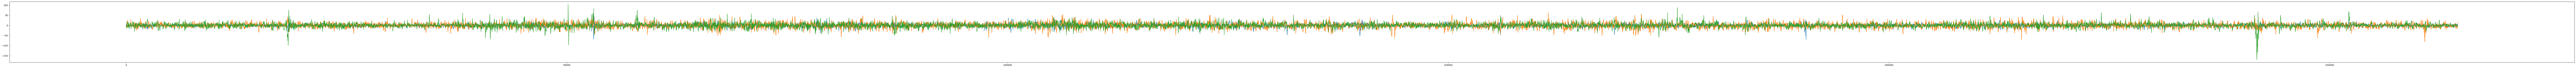

In [60]:
def PrintTargetTrend(df: pd.DataFrame, stocks: List[int], field: str) -> None:
    x_axis_list: List[List[float]] = []
    y_axis_list: List[List[float]] = []

    for stock in stocks:
        stock_df: pd.DataFrame = df.loc[df['stock_id'] == stock]
        x_axis: List[float] = []
        y_axis: List[float] = []

        for idx, row in stock_df.iterrows():
            if pd.isnull(stock_df.at[idx, field]):
                continue
            x_axis.append(float(row['date_id'] * 550 + row['seconds_in_bucket']))
            y_axis.append(float(row[field]))

        x_axis_list.append(x_axis)
        y_axis_list.append(y_axis)

    if len(x_axis_list) != len(y_axis_list):
        raise RuntimeError
    
    plt.figure().set_figwidth(200)

    for idx in range(len(x_axis_list)):
        plt.plot(x_axis_list[idx], y_axis_list[idx])
    
    plt.show()

PrintTargetTrend(df=df, stocks=[0, 1, 2], field='target')

## Correlation of Stocks By Target

In [177]:
def StockCorr(df: pd.DataFrame, field: str) -> pd.DataFrame:
    date_list: List[int] = df['date_id'].unique().tolist()
    date_list.sort(reverse=False)
    stock_list: List[int] = df['stock_id'].unique().tolist()
    stock_list.sort(reverse=False)
    sec_per_date: int = len(df['seconds_in_bucket'].unique().tolist())
    converted_df: pd.DataFrame = pd.DataFrame(
        index=list(range(sec_per_date * len(date_list))), columns=stock_list
    )

    with tqdm(total=df.shape[0], desc='Iterate over all rows in the DataFrame') as pbar:
        for idx, row in df.iterrows():
            if pd.isnull(df.at[idx, 'date_id']):
                continue
            if pd.isnull(df.at[idx, 'seconds_in_bucket']):
                continue
            if pd.isnull(df.at[idx, 'stock_id']):
                continue
            if pd.isnull(df.at[idx, field]):
                continue

            timestamp: int = int((row['date_id'] * 550 + row['seconds_in_bucket']) / 10)
            stock_id: int = int(row['stock_id'])
            value: float = float(row[field])
            converted_df.at[timestamp, stock_id] = value
            pbar.update(1)

    return converted_df.corr()


def PrintCorrPercentiles(ndarr: np.ndarray, percentiles: List[int]) -> None:
    ndarr_copy: np.ndarray = ndarr.copy()
    ndarr_copy = ndarr_copy + 1
    quartile_ndarr: np.ndarray = np.zeros((ndarr.shape[0], len(percentiles)))

    for row in range(ndarr_copy.shape[0]):
        row_arr: np.ndarray = ndarr_copy[row, :]
        row_arr[row] = np.nan
        row_arr = row_arr[~np.isnan(row_arr)]
        if len(row_arr) == 0:
            continue
        quartile_ndarr[row] = np.percentile(row_arr, percentiles)

    quartile_ndarr = quartile_ndarr - 1

    for idx in range(quartile_ndarr.shape[0]):
        print(f'Row {idx:3}: {quartile_ndarr[idx, :]}')


def PrintHighCorrList(ndarr: np.ndarray, cnt: int) -> None:
    ndarr_copy: np.ndarray = ndarr.copy()
    ndarr_copy = ndarr_copy + 1

    for row in range(ndarr_copy.shape[0]):
        row_arr: np.ndarray = ndarr_copy[row, :]
        row_arr[row] = np.nan
        row_arr[np.isnan(row_arr)] = 0
        if len(row_arr) == 0:
            continue
        idx_arr: np.ndarray = np.argsort(row_arr)
        if cnt < len(idx_arr):
            idx_arr = idx_arr[-cnt:]
        idx_arr = np.flip(idx_arr)

        msg: str = f'Stock{row:4} -> '
        for idx in idx_arr:
            corr: float = (row_arr[idx] - 1) * 100
            msg += f'Stock{idx: 4}:{corr: 3.3f}%, '
        print(msg)


def GroupByCorr(ndarr: np.ndarray, threshold: np.float64) -> None:
    groups: List[Set[int]] = []

    for row_stock in range(ndarr.shape[0]):
        for col_stock in range(ndarr.shape[1]):
            if row_stock == col_stock:
                continue
            if ndarr[row_stock][col_stock] >= threshold:
                # iterate over groups
                pushed: bool = False

                for groups_idx in range(len(groups)):
                    if row_stock in groups[groups_idx] and col_stock in groups[groups_idx]:
                        pushed = True
                        continue

                    qualified: bool = True

                    # row_stock exists in groups[groups_idx], check col_stock
                    if row_stock in groups[groups_idx]:
                        for stock in list(groups[groups_idx]):
                            if ndarr[col_stock][stock] < threshold:
                                qualified = False
                                break
                    # col_stock exists in groups[groups_idx], check row_stock
                    if col_stock in groups[groups_idx]:
                        for stock in list(groups[groups_idx]):
                            if ndarr[row_stock][stock] < threshold:
                                qualified = False
                                break
                    if row_stock not in groups[groups_idx] and col_stock not in groups[groups_idx]:
                        qualified = False
                    if qualified:
                        groups[groups_idx].add(row_stock)
                        groups[groups_idx].add(col_stock)
                        pushed = True

                if not pushed:
                    groups.append(set([row_stock, col_stock]))

    for idx in range(len(groups)):
        print(f'Group {idx:2}: {groups[idx]}')


def DbscanGroupByCorr(ndarr: np.ndarray, eps: float, min_samples: int):
    def GetCorr(a, b) -> np.float64:
        return 1 - ndarr[a][b]

    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    dbscan.fit(ndarr)
    labels = dbscan.labels_
    print("Cluster labels:", labels)

In [153]:
def TargetCorr(df: pd.DataFrame) -> np.ndarray:
    corr_df: pd.DataFrame = StockCorr(df=df, field='target')
    corr_df: np.ndarray = corr_df.to_numpy()
    # PrintCorrPercentiles(corr_df, percentiles=[0, 20, 40, 60, 80, 90, 100])
    PrintHighCorrList(ndarr=corr_df, cnt=10)
    return corr_df

target_corr_df: np.ndarray = TargetCorr(df=df)

Iterate over all rows in the DataFrame: 100%|█████████▉| 5237892/5237980 [02:46<00:00, 31553.41it/s]


Stock   0 -> Stock 160: 40.884%, Stock 105: 33.991%, Stock 121: 31.908%, Stock 166: 27.284%, Stock 148: 23.639%, Stock 195: 23.260%, Stock 123: 20.999%, Stock  30: 20.849%, Stock   3: 20.782%, Stock  12: 20.752%, 
Stock   1 -> Stock  47: 13.978%, Stock  33: 7.539%, Stock 132: 7.173%, Stock  63: 6.771%, Stock 177: 6.697%, Stock   4: 6.589%, Stock 173: 6.287%, Stock 146: 6.153%, Stock 165: 6.150%, Stock 114: 6.057%, 
Stock   2 -> Stock  47: 7.647%, Stock  97: 7.074%, Stock 177: 7.016%, Stock 117: 6.811%, Stock 119: 6.596%, Stock  24: 6.347%, Stock  62: 6.217%, Stock 167: 6.190%, Stock  63: 6.169%, Stock 146: 6.058%, 
Stock   3 -> Stock 105: 35.719%, Stock 160: 33.881%, Stock 148: 32.977%, Stock 195: 32.264%, Stock  30: 30.146%, Stock 144: 29.506%, Stock 166: 29.353%, Stock 123: 29.335%, Stock  12: 28.894%, Stock  55: 27.773%, 
Stock   4 -> Stock 165: 25.093%, Stock 139: 23.706%, Stock   8: 18.567%, Stock 130: 18.287%, Stock  35: 17.789%, Stock 182: 17.704%, Stock  47: 16.846%, Stock 105:

In [193]:
print('Threshold = 0.8')
GroupByCorr(ndarr=target_corr_df, threshold=0.8)
print('')
print('Threshold = 0.7')
GroupByCorr(ndarr=target_corr_df, threshold=0.7)
print('')
print('Threshold = 0.6')
GroupByCorr(ndarr=target_corr_df, threshold=0.6)

Threshold = 0.8
Group  0: {84, 175}

Threshold = 0.7
Group  0: {84, 175}
Group  1: {195, 148}

Threshold = 0.6
Group  0: {195, 148, 30}
Group  1: {84, 175}
Group  2: {160, 105}


In [150]:
def ReferencePriceCorr(df: pd.DataFrame) -> np.ndarray:
    corr_df: pd.DataFrame = StockCorr(df=df, field='reference_price')
    corr_df: np.ndarray = corr_df.to_numpy()
    # PrintCorrPercentiles(corr_df, percentiles=[0, 20, 40, 60, 80, 90, 100])
    PrintHighCorrList(ndarr=corr_df, cnt=10)
    return corr_df

ref_price_corr_df: np.ndarray = ReferencePriceCorr(df=df)

Iterate over all rows in the DataFrame: 100%|█████████▉| 5237760/5237980 [02:47<00:00, 31187.11it/s]


Stock   0 -> Stock 160: 62.113%, Stock  55: 57.315%, Stock 163: 57.176%, Stock 169: 56.999%, Stock 105: 55.200%, Stock 133: 54.521%, Stock  45: 54.430%, Stock 130: 53.839%, Stock 175: 53.744%, Stock  14: 53.671%, 
Stock   1 -> Stock   7: 46.940%, Stock  41: 46.741%, Stock  95: 46.412%, Stock  47: 46.368%, Stock 141: 45.939%, Stock 169: 45.744%, Stock 106: 45.736%, Stock  84: 45.435%, Stock 183: 44.968%, Stock 164: 44.791%, 
Stock   2 -> Stock 106: 47.040%, Stock   7: 46.345%, Stock 183: 46.020%, Stock 116: 45.190%, Stock 175: 45.123%, Stock 168: 44.871%, Stock  58: 44.732%, Stock 126: 44.712%, Stock  84: 44.705%, Stock 141: 44.664%, 
Stock   3 -> Stock  55: 62.422%, Stock 130: 58.770%, Stock 160: 57.087%, Stock  37: 56.614%, Stock 151: 56.543%, Stock 163: 56.531%, Stock  39: 55.677%, Stock 109: 55.287%, Stock  68: 55.235%, Stock 149: 54.620%, 
Stock   4 -> Stock 130: 60.468%, Stock  55: 59.249%, Stock 169: 58.385%, Stock 164: 58.248%, Stock  75: 57.189%, Stock  45: 57.150%, Stock  84: 

In [145]:
DbscanGroupByCorr(ref_price_corr_df, eps=0.1, min_samples=2)

Cluster labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1  0 -1 -1 -1  0 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  0 -1  0  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [191]:
print('Threshold = 0.9')
GroupByCorr(ndarr=ref_price_corr_df, threshold=0.9)
print('')
print('Threshold = 0.8')
GroupByCorr(ndarr=ref_price_corr_df, threshold=0.8)

Threshold = 0.9
Group  0: {84, 175}

Threshold = 0.8
Group  0: {141, 7}
Group  1: {17, 141}
Group  2: {84, 175}
Group  3: {140, 183}
